# Project topic: 
- What are the interesting features, relationships, and trends of football matches in a league season? 
- Could the rumor that the home team generally performs better than the away team is true? How to prove it statistically?
- And many more questions..

# Tasks:
- Explore the dataset using Machine Learning methods. (Regression, Classification, PCA, etc).
- Create visualizations to highlight the trends in the data 

## Data source: 
The data was collected and distributed by Football-Data.co.uk. For this project we are using the results of the Premier league in seasons 2016, 2017 and 2018. The data have been split in train and test (approximately 70% of the data are the training set, and 30% are the test set), and are divided in 4 .csv files:
- football train x: contains 798 observations and 13 columns as features.
- football train y: contains the labels “FTG" (full time goal which is the total number of goals in the whole
match) that you will need for the regression task and “Interest" for classification for these 798 observations.
- football test x and football test y sets have the same respective structure and contain 342 observations.

# Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import statsmodels.api as sm
from utils import *

In [2]:
# Change to the csv file storage
os.chdir("../Football_data")

# Load the csv file
trained_data = pd.read_csv('football_train_x.csv')

# Map the features with its corresponding description 
trained_data.rename(columns={'HTHG': 'Half-time Home Goal','HTAG': 'Half-time Away Goal', 'HTR': 'Half-time result',
                            'HS': 'Home shot', 'AS': 'Away shot', 'HST': 'Home shot on-target', 'AST': 'Away shot on-target',
                            'HF': 'Home foul', 'AF': 'Away foul', 'HC': 'Home corner', 'AC': 'Away corner'}, inplace=True)

## Feature Relationship Extraction

In order to have an intuitive view into the relationship between the features in the dataset, we could draw the correlation matrix:

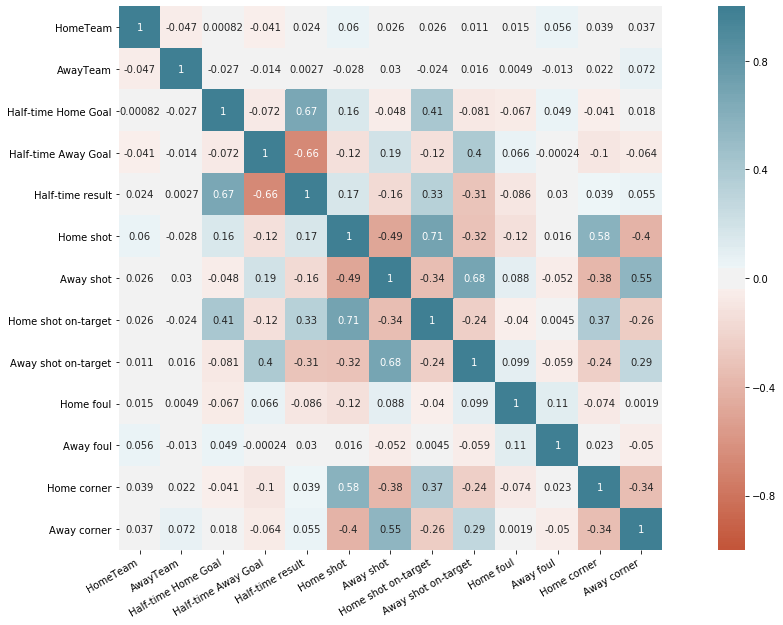

In [3]:
# Visualize the relationship of the features using heatmap by calculating column correlations and making a seaborn heatmap
corr = trained_data.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True, ax=ax 
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=30,
    horizontalalignment='right'
);

**Given the correlation matrix, there are a few interesting features that are significantly correlated to other feature. (HTHG vs HTR, HTAG vs HTR, HC vs HS, AC vs AS).**

We could visualize how strong the correlation is by using the pairplot: 

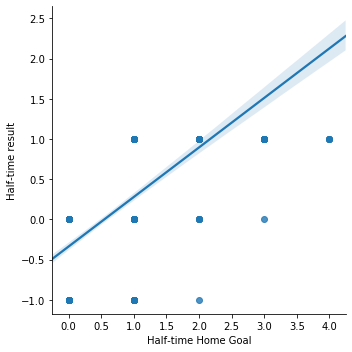

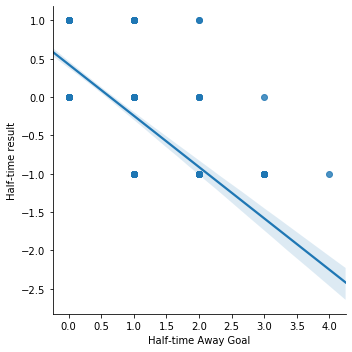

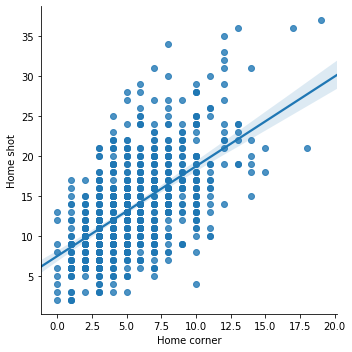

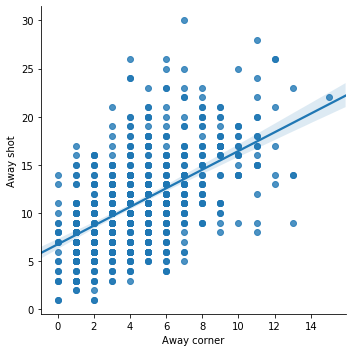

In [4]:
# Create pairplots to see the linear relationship of some interesting features
pairplot('Half-time Home Goal', 'Half-time result', trained_data)
pairplot('Half-time Away Goal', 'Half-time result', trained_data)
pairplot('Home corner', 'Home shot', trained_data)
pairplot('Away corner', 'Away shot', trained_data)

# Principal Component Analysis (PCA) for Data Visualization

## Standardize the Data

PCA is effected by scale so you need to scale the features in your data before applying PCA. Use **Standard Scaler** to standardize the dataset's features into unit scale (mean = 0, variance = 1), which is a requirement for the optimal performance of many machine learning algorithms.

In [5]:
from sklearn.preprocessing import StandardScaler
features = ['HomeTeam','AwayTeam','Half-time Home Goal','Half-time Away Goal', 'Half-time result',
           'Home shot', 'Away shot', 'Home shot on-target', 'Away shot on-target',
           'Home foul', 'Away foul', 'Home corner', 'Away corner']

# Separate the features
x = trained_data.loc[:,features].values
# Standardize the features
x = StandardScaler().fit_transform(x)

In [6]:
from sklearn.decomposition import PCA
# Create the covariance matrix 
covar_matrix = PCA(n_components=13) # we have 13 features
principalComponents = covar_matrix.fit_transform(x)
pca_cols = []
for i in range(1,14):
    ele = 'PCA ' + str(i)
    pca_cols.append(ele)
principalDf = pd.DataFrame(data = principalComponents
             , columns = pca_cols)

## Explained Variance

The explained variance indicates how much information each component accounts for in the dataset:

In [7]:
covar_matrix.explained_variance_ratio_

array([0.26021796, 0.14717306, 0.09922078, 0.08767236, 0.07952791,
       0.07809176, 0.06764957, 0.06008773, 0.04237117, 0.03601364,
       0.01860837, 0.01613536, 0.00723031])

**It can be seen from the explained variance that the first PCA component accounts for approximately 26%, the second PCA accounts for around 14.7% of information of the dataset, and so on..**

Plotting the cumulative explained variance gives a better intuition of how features account for the percentage of the information of the dataset: 

In [8]:
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([ 26. ,  40.7,  50.6,  59.4,  67.4,  75.2,  82. ,  88. ,  92.2,
        95.8,  97.7,  99.3, 100. ])

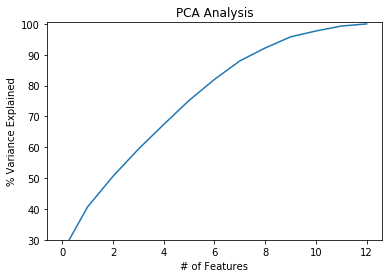

In [9]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

The plot assists in choosing the number of features accounting for the majority of the information of the dataset.

From the graph, the 3 first components already account for 50.6% of the dataset information. Choosing 9 PCA components explain 92.2% variation of the data. 

# Simple Linear Regression

## Understanding the contributing factor to the total number of goals

Being a person having football as the most favorite sport, watching football is interesting in case goals occur multiple times during the match.

Firstly, I would like to explore what are the strongest predictors contributing to the excitement of the match (number of goals).

Secondly,

**Hypothesis testing:** It is usually true that the home team would perform better than the away team, due to the familiarity of the stadium and its supporters. 

### Half-time Home Goal versus Total Goals

In [10]:
from sklearn import linear_model

# Load the csv file 
FTG = pd.read_csv('football_train_y.csv')

# Feature (Half-time Home Goal)
x_train_home = trained_data['Half-time Home Goal'].values.reshape(-1,1)

# Target (the total number of goals)
y_train = FTG.iloc[:,1].to_frame(name='Total goals').values.reshape(-1,1)

# Initialize the model
lm = linear_model.LinearRegression()

# Fit the training features and expected target to the model
model = lm.fit(x_train_home,y_train)

# Make a prediction on testing data
x_test = pd.read_csv('football_test_x.csv')
x_test_home = x_test['HTHG'].values.reshape(-1,1)

Evaluate the coefficient of determination (R-squared) value:

In [11]:
model.score(x_train_home, y_train)

0.23814747678620585

**R-squared value interpretation:** it implies that approximately 24% of the point would fall into the regression line.

When adding new data points into the model, we can check whether the R-squared value increases with maximum to 1 (the line fits perfectly) or decreases to 0 (the line does not fit any point).

The higher the coefficient of determination (R-squared value), the better the model performs.

Inspect the coefficients of the model:

In [12]:
lm.coef_

array([[0.93553871]])

This means that for every one unit of change in total goals, the change in the Half-time Home Goal is approximately 94%.

### Half-time Away Goal versus Total Goals

In [13]:
from sklearn import linear_model

# Feature (Half-time Home Goal)
x_train_away = trained_data['Half-time Away Goal'].values.reshape(-1,1)

# Initialize the model
lm = linear_model.LinearRegression()

# Fit the training features and expected target to the model
model = lm.fit(x_train_away,y_train)

# Make a prediction on testing data
x_test = pd.read_csv('football_test_x.csv')
x_test_away = x_test['HTAG'].values.reshape(-1,1)
y_pred_away = model.predict(x_test_away)

Evaluate the coefficient of determination (R-squared) value:

In [14]:
model.score(x_train_away, y_train)

0.18179320787715714

This means that approximately 18% of all the points are in the linear regression line.

In [15]:
model.coef_

array([[0.88946679]])

This means that for every one unit of change in total goals, the change in the Half-time Home Goal is about 89%.

**Given the coefficient values of both Half-time Home Goal and Half-time Away Goal as 94% and 89% respectively, it can be inferred that the Home Team Goal contributes to the Total Goal more than that of Away Goal, and Home Team Goal performs mostly better than the Away Team in the total 798 matches.**

## Make Predictions 

In [16]:
# Make predictions for the total goals using Half-time Home Goal
y_pred_home = model.predict(x_test_home)

# Make predictions for the total goals using Half-time Away Goal
y_pred_away = model.predict(x_test_away)

In [17]:
# CSS code to display 2 tables in the same cell
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [18]:
y_test = pd.read_csv('football_test_y.csv').iloc[:,1]
df_home = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_home.flatten()})
df_away = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_away.flatten()})
display(df_home)
display(df_away)

,Actual,Predicted
0,1,2.200604
1,5,2.200604
2,2,3.090071
3,5,3.979538
4,1,2.200604
5,4,2.200604
6,2,2.200604
7,3,3.090071
8,3,3.090071
9,4,2.200604


,Actual,Predicted
0,1,2.200604
1,5,3.090071
2,2,3.090071
3,5,2.200604
4,1,3.090071
5,4,2.200604
6,2,2.200604
7,3,2.200604
8,3,3.090071
9,4,3.979538


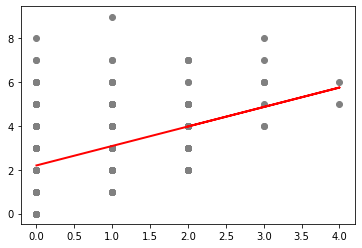

In [19]:
# Plot the Linear chart showing the relationship (Half-time Home Goal vs Total Goals)
plt.scatter(x_test_home, y_test,  color='gray')
plt.plot(x_test_home, y_pred_home, color='red', linewidth=2)
plt.show()

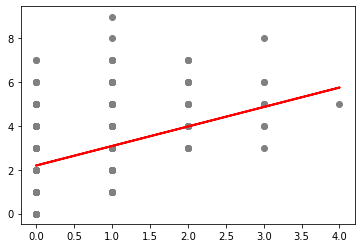

In [20]:
# Plot the Linear chart showing the relationship (Half-time Away Goal vs Total Goals)
plt.scatter(x_test_away, y_test,  color='gray')
plt.plot(x_test_away, y_pred_away, color='red', linewidth=2)
plt.show()

**The two above graphs and the tables show that the model is not able to fit and predict the data with acceptable accuracy. The data points largely deviate from the line in the chart, and there are large differences between actual and predicted points in the table.** 

**In addition, the R-squared value is only 0.18, which indicates that the model is not good enough.**

One assumption is the total goal (target) is affected by multiple features, which could be proved by experimenting with Multiple Linear Regression.

## Multiple Linear Regression

In [21]:
y_train = FTG.iloc[:,1].values

In [22]:
x_train_multi = pd.read_csv('football_train_x.csv')
x_train_multi = x_train_multi[['HTHG', 'HTAG', 'HST', 'AST', 'HC', 'AC']].values

In [23]:
from sklearn.linear_model import LinearRegression

# Import the test data
#x_train_multi = pd.read_csv('football_train_x.csv')
#x_train_multi = x_train_multi[]
# Train the model 
multi_lm_model = LinearRegression()
multi_lm_model.fit(x_train_multi, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Check the distribution of total goals:

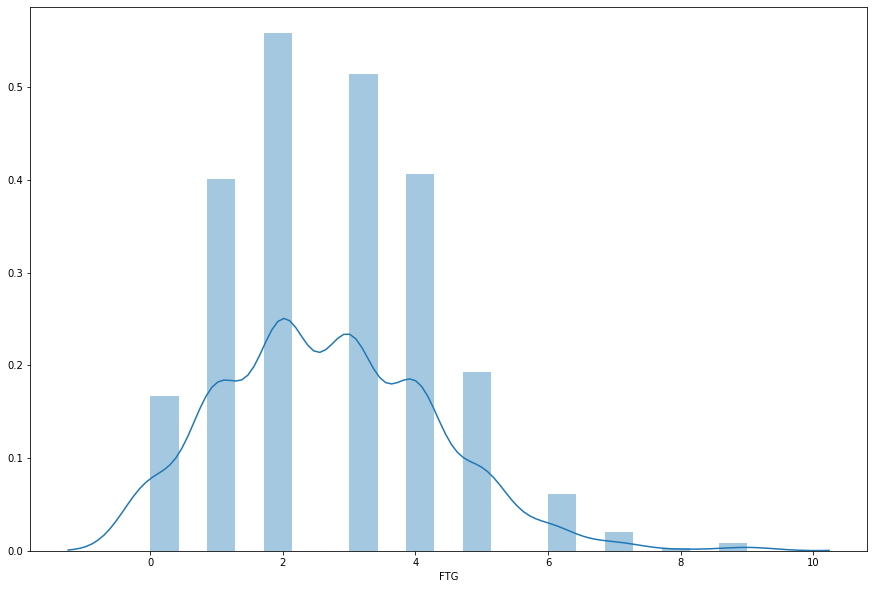

In [24]:
import seaborn as sns 
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(FTG['FTG'])

**As can be seen from the chart, most of the values are around 1,2,3 goals per match.**

### Make Predictions

In [25]:
# Import the testing data
x_test_multi = pd.read_csv('football_test_x.csv')
x_test_multi = x_test_multi[['HTHG', 'HTAG', 'HST', 'AST', 'HC', 'AC']].values

# Make a prediction for y-value
y_test = pd.read_csv('football_test_y.csv')
y_pred_multi = multi_lm_model.predict(x_test_multi)

In the case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. To see what coefficients our regression model has chosen, I execute the following script:

In [26]:
features = ['HTHG', 'HTAG', 'HST', 'AST', 'HC', 'AC']
coeff_df = pd.DataFrame(multi_lm_model.coef_, features, columns=['Coefficient'])  
coeff_df

,Coefficient
HTHG,0.805608
HTAG,0.797288
HST,0.160587
AST,0.172051
HC,-0.039314
AC,-0.017801


**This means that for every unit increases in the total goal, there is an increase of 0.86 units in the Half-time Home Goal (HTHG). Similarly, 0.73 unit increase in the Half-time Away Goal (HTAG) result in one total goal increase.**

**It is interesting to see that, the AST weights higher than that of HST, which shows that if the away team shoots on target the same number to the home team, it is more likely to convert it to a goal.** 

Evaluate the goodness of the model by comparing actual and predicted outcomes:

In [27]:
y_test = pd.read_csv('football_test_y.csv').iloc[:,1]
df_home = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_multi.flatten()})
display(df_home)

,Actual,Predicted
0,1,0.980075
1,5,3.065975
2,2,3.930994
3,5,3.240681
4,1,2.214560
5,4,2.791678
6,2,1.620177
7,3,2.611217
8,3,2.834356
9,4,3.596959


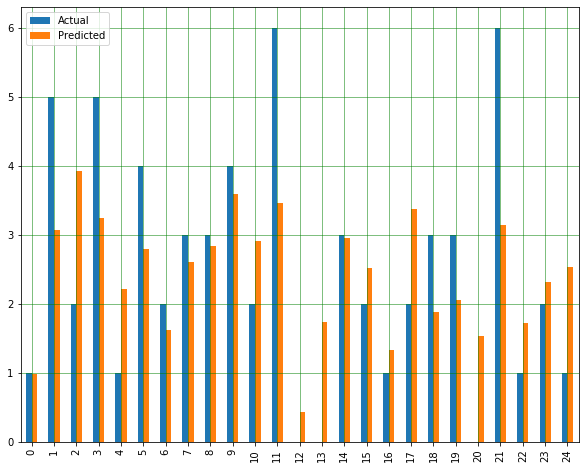

In [28]:
df1 = df_home.head(25)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Principal Component Analysis (PCA) for Dimensionality Reduction

Usually in practice, only a few (not all) features are informative and have the correlations with each other. 
We could reduce the dimension of the data by applying PCA: 

In [29]:
from sklearn.decomposition import PCA

# Create the covariance matrix 
covar_matrix = PCA(n_components=13) # we have 13 features
principalComponents = covar_matrix.fit_transform(x)
pca_cols = []
for i in range(1,14):
    ele = 'PCA ' + str(i)
    pca_cols.append(ele)
principalDf = pd.DataFrame(data = principalComponents
             , columns = pca_cols)

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

[]

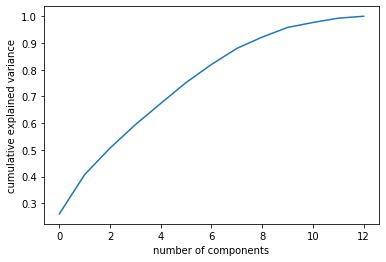

In [30]:
plt.plot(np.cumsum(covar_matrix.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.plot()
#var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
#var #cumulative sum of variance explained with [n] features

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components. For example, we see that with the digits the first 9 components contain approximately 90% of the variance, while you need around 12 components to describe close to 100% of the variance.

**We'd need about 9 components to retain 90% of the variance.**


# Classification

In this task, I will classify the football match as interesting or not based on its proximity to other classes.

## K-nearest neighbours

In [31]:
# Import the training data
x_train_interest = pd.read_csv('football_train_x.csv')
y_train_interest = pd.read_csv('football_train_y.csv')
y_train_interest = y_train_interest.iloc[:,0]

# Testing data
x_test_interest = pd.read_csv('football_test_x.csv')
y_test_interest = pd.read_csv('football_test_y.csv')
y_test_interest = y_test_interest.iloc[:,0]

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

# An auxiliary function to initialize the model and make predictions
def skl_knn(k, test_data, test_target, stored_data, stored_target):
    """k: number of neighbors to use in classication
    test_data: the data/targets used to test the classifier
    stored_data: the data/targets used to classify the test_data
    """
    
    classifier = KNeighborsClassifier(n_neighbors=k)  
    classifier.fit(stored_data, stored_target)

    y_pred = classifier.predict(test_data)
    return (test_target, y_pred)

In [33]:
# Create KNN instance
# n_neighbors -> argument identifies the amount of neighbors used to ID classification
knn = KNeighborsClassifier(n_neighbors=3)

# Fit (i.e. training) the model
knn.fit(x_train_interest, y_train_interest)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Make predictions

With k = 3:

In [34]:
# Initialize the model with k=3
(y_target, y_pred) = skl_knn(3, x_test_interest, y_test_interest, x_train_interest, y_train_interest)

### We can evaluate the accuracy of the model by looking at the confusion matrix and classification report

**Classification report:**

In [35]:
print(classification_report(y_target, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66       194
           1       0.53      0.43      0.48       148

    accuracy                           0.59       342
   macro avg       0.57      0.57      0.57       342
weighted avg       0.58      0.59      0.58       342



**Given the classification report, we conclude that:**
    
   * For all instances classified positive, it classifies correctly 90% non-interesting matches and 71% interesting matches.
   * For all instances that were actually positive, it classifies correctly 85% of all interesting matches and 80% of all non-interesting matches.

Another way of evaluating our model is to compute the confusion matrix. The numbers on the diagonal of the confusion matrix correspond to correct predictions whereas the others imply false positives and false negatives.

In [36]:
# Print out confusion matrix
cmat = confusion_matrix(y_test_interest, y_pred)
print("Confusion matrix: \n", cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion matrix: 
 [[137  57]
 [ 84  64]]
TP - True Negative 137
FP - False Positive 57
FN - False Negative 84
TP - True Positive 64
Accuracy Rate: 0.5877192982456141
Misclassification Rate: 0.41228070175438597


According to the confusion matrix, the model is able to predict correctly 201/342 data points = 58.7% accuracy.

### Improve the Model

At this point, we might ask how to improve the accuracy of the model. One way to accomplish this is to try to modify the k value (the number of nearest neighbours) used to match the classification on unseen data. 

We can check by generating the model on different values of K and check their performance.

To simplify the process of evaluating multiple cases of k-values, we create a function to derive the error using the average where our predictions were not equal to the test values.

In [37]:
# Generate function to add error rates of KNN with various k-values
# error_rate -> empty list to gather error rates at various k-values
# for loop -> loops through k values 1 to 39
# knn -> creates instance of KNeighborsClassifier with various k
# knn.fit -> trains the model
# pred_i -> conducts predictions from model on test subset
# error_rate.append -> adds error rate of model with various k-value, using the average where prediction not
# equal to the test values
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_interest, y_train_interest)
    pred_i = knn.predict(x_test_interest)
    error_rate.append(np.mean(pred_i != y_test_interest))

## Plot the error chart

Text(0, 0.5, 'Error Rate')

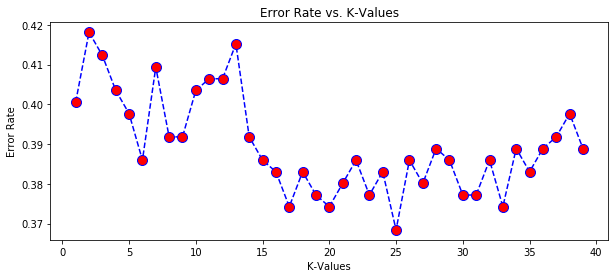

In [38]:
# Configure and plot error rate over k values
plt.figure(figsize=(10,4))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

Here we see that the error rate continues to decrease as we increase the k-value. It clearly shows that at k = 25, the error rate is minimum, thus giving the reasonable classifier result.

### Adjusted k-value 

Initialize the model with adjusted value k = 25:

In [39]:
(y_target, y_pred) = skl_knn(25, x_test_interest, y_test_interest, x_train_interest, y_train_interest)

Evaluate the classification and confusion matrix:

In [40]:
print(classification_report(y_target, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.89      0.73       194
           1       0.67      0.30      0.41       148

    accuracy                           0.63       342
   macro avg       0.64      0.59      0.57       342
weighted avg       0.64      0.63      0.59       342



In [41]:
# Print out confusion matrix
cmat = confusion_matrix(y_test_interest, y_pred)
print("Confusion matrix: \n", cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion matrix: 
 [[172  22]
 [104  44]]
TP - True Negative 172
FP - False Positive 22
FN - False Negative 104
TP - True Positive 44
Accuracy Rate: 0.631578947368421
Misclassification Rate: 0.3684210526315789


**When k = 25, the accuracy rate increases by 5%, and the model is able to predict whether a match is interesting or not with accuracy 63%, which is not totally accurate but still gives decent prediction.**